<a href="https://colab.research.google.com/github/mcprodrigues/modelo-ia-pokedex/blob/main/pokedex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/desafio_ia_vortex_v1/dataset.csv')
print(f"Classes únicas encontradas no dataset: {df['label'].unique()}")

# Label encoding
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

# Exibir a correspondência entre labels e números
for i, class_name in enumerate(le.classes_):
    print(f'{class_name} -> {i}')

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label_enc'], random_state=42)


Classes únicas encontradas no dataset: ['cow' 'goat' 'ostrich' 'pigeon' 'iguana' 'possum' 'peacock' 'cat'
 'lizard' 'horse']
cat -> 0
cow -> 1
goat -> 2
horse -> 3
iguana -> 4
lizard -> 5
ostrich -> 6
peacock -> 7
pigeon -> 8
possum -> 9


In [ ]:
class AnimalsDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.annotations = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.loc[index, 'image_path'])
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f'Arquivo não encontrado: {img_path}')

            return self.__getitem__((index + 1) % len(self.annotations))

        y_label = torch.tensor(self.annotations.loc[index, 'label_enc'])

        if self.transform:
            image = self.transform(image)

        return image, y_label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


In [ ]:
train_dataset = AnimalsDataset(train_df, root_dir='/content/drive/MyDrive/', transform=train_transform)
test_dataset = AnimalsDataset(test_df, root_dir='/content/drive/MyDrive/', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
class ClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(ClassifierCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = ClassifierCNN(len(le.classes_))


In [ ]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def eval_epoch(model, dataloader, loss_fn):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer)
    val_loss, val_acc = eval_epoch(model, test_loader, loss_fn)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10


100%|██████████| 14/14 [01:22<00:00,  5.92s/it]


Train Loss: 0.7313, Train Acc: 0.7618
Val Loss: 0.6342, Val Acc: 0.8047
Epoch 2/10


100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


Train Loss: 0.4241, Train Acc: 0.8707
Val Loss: 0.6426, Val Acc: 0.7930
Epoch 3/10


100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


Train Loss: 0.2395, Train Acc: 0.9208
Val Loss: 0.7100, Val Acc: 0.8023
Epoch 4/10


100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


Train Loss: 0.0937, Train Acc: 0.9761
Val Loss: 0.7684, Val Acc: 0.8047
Epoch 5/10


100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


Train Loss: 0.0645, Train Acc: 0.9802
Val Loss: 0.7960, Val Acc: 0.7930
Epoch 6/10


100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


Train Loss: 0.0388, Train Acc: 0.9849
Val Loss: 0.9744, Val Acc: 0.7953
Epoch 7/10


100%|██████████| 14/14 [00:11<00:00,  1.20it/s]


Train Loss: 0.0711, Train Acc: 0.9814
Val Loss: 0.8794, Val Acc: 0.8302
Epoch 8/10


100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


Train Loss: 0.0211, Train Acc: 0.9918
Val Loss: 0.9727, Val Acc: 0.7930
Epoch 9/10


100%|██████████| 14/14 [00:12<00:00,  1.14it/s]


Train Loss: 0.0298, Train Acc: 0.9901
Val Loss: 0.9183, Val Acc: 0.8047
Epoch 10/10


100%|██████████| 14/14 [00:11<00:00,  1.17it/s]

Train Loss: 0.0306, Train Acc: 0.9907
Val Loss: 1.2070, Val Acc: 0.7744


In [ ]:
# Get predictions and labels from the test set
all_preds, all_labels = get_all_preds_and_labels(model, test_loader)

# Calculate metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

metrics_dict = {
    'Métrica': ['Acurácia', 'Precisão (weighted)', 'Recall (weighted)', 'F1-score (weighted)'],
    'Valor': [acc, prec, rec, f1]
}

df_metrics = pd.DataFrame(metrics_dict)
df_metrics['Valor'] = df_metrics['Valor'].apply(lambda x: f"{x:.4f}")
df_metrics.style.set_properties(**{'text-align': 'center'})

,Métrica,Valor
0,Acurácia,0.7744
1,Precisão (weighted),0.8103
2,Recall (weighted),0.7744
3,F1-score (weighted),0.7736


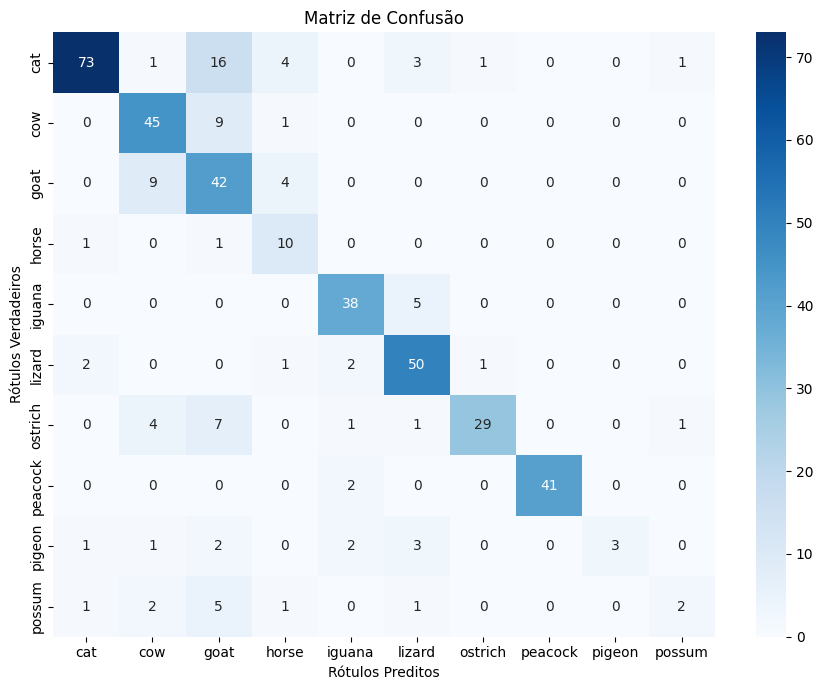

In [ ]:
# 1) Gera a matriz de confusão em numpy
cm = confusion_matrix(all_labels, all_preds)

# 2) Plot usando seaborn (heatmap) ou matplotlib puro
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=True,              # mostra os números dentro das células
    fmt='d',                 # formata como inteiro
    cmap='Blues',            # paleta de cores (pode escolher outra)
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel('Rótulos Preditos')
plt.ylabel('Rótulos Verdadeiros')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()
